In [1]:
# Clone the SAM repository
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e .

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp310-cp310-linux_x86_64.whl size=12321 sha256=de8c7645037df1d3e06bb0cef2a79b967e8e574312caef8e18cd702908d34df8
  Stored in directory: /tmp/pip-ephem-wheel-cache-qwnxdoea/wheels/7d/af/fe/c05425a1fdc391329545b53111d5cabdfc241ee07cab053945
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0


In [2]:
# Download the all 4 checkpoints
%cd checkpoints
!./download_ckpts.sh

/content/segment-anything-2/checkpoints
--2024-09-04 18:01:20--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.125.58, 3.162.125.48, 3.162.125.57, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.125.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   220MB/s    in 0.7s    

2024-09-04 18:01:20 (220 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2024-09-04 18:01:20--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.125.58, 3.162.125.48, 3.162.125.57, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.125.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [3]:
!pip install torch torchvision
!pip install Pillow

In [4]:
# Download CMU 3D dataset
!wget http://www.cs.cmu.edu/~ehsiao/3drecognition/CMU10_3D.zip -O CMU10_3D.zip

# Extract the dataset
import zipfile
with zipfile.ZipFile("CMU10_3D.zip", 'r') as zip_ref:
    zip_ref.extractall("CMU10_3D")

--2024-09-04 18:01:50--  http://www.cs.cmu.edu/~ehsiao/3drecognition/CMU10_3D.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121503865 (116M) [application/zip]
Saving to: ‘CMU10_3D.zip’

CMU10_3D.zip        100%[===================>] 115.88M  5.06MB/s    in 23s     

2024-09-04 18:02:13 (5.01 MB/s) - ‘CMU10_3D.zip’ saved [121503865/121503865]



In [48]:
# Now importing the necessary functions
import torch
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os, glob, shutil
import matplotlib.patches as patches
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2_video_predictor
from pycocotools import mask as mask_utils

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [50]:
# Path to the model checkpoint and config file
checkpoint = "./sam2_hiera_tiny.pt"
model_cfg = "./sam2_hiera_t.yaml"

In [51]:
# Initialize the model
predictor_prompt = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))
sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)
predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device=device)

Helper function

In [52]:
# Helper function to create directory
def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

# Helper function to clear temporary directory
def cleardir(tempfolder):
    filepaths = glob.glob(tempfolder + "/*")
    for filepath in filepaths:
        os.unlink(filepath)

# Show mask on the plot
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])

        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

# Show bounding box on the plot
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor='none', lw=2))

Process the Initial Image and Mask to Get Bounding Box:

In [53]:
# Process image and its corresponding mask to get bounding box
def process_img_png_mask(imgpath, maskpath):
    img = Image.open(imgpath)
    mask = Image.open(maskpath).convert("L")  # Convert to grayscale

    mask_np = np.array(mask)
    indices = np.where(mask_np > 0)
    ymin, ymax = indices[0].min(), indices[0].max()
    xmin, xmax = indices[1].min(), indices[1].max()

    return [xmin, xmax, ymin, ymax]

 Track Objects in Multiple Images:

In [54]:
def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    tempfolder = "./tempdir"
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)

    shutil.copy(imgpath1, tempfolder + "/00000.jpg")
    shutil.copy(imgpath2, tempfolder + "/00001.jpg")

    inference_state = predictor_vid.init_state(video_path="./tempdir")
    predictor_vid.reset_state(inference_state)

    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)

        _, out_obj_ids, out_mask_logits = predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box
        )

    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    if visualize:
        fig, ax = plt.subplots()
        plt.title(f"Original Image object::")
        ax.imshow(Image.open(tempfolder + "/00000.jpg"))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"Detected Object in Test Image:")
        plt.imshow(Image.open(tempfolder + "/00001.jpg"))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    return video_segments

Calculate Performance (IoU):

In [55]:

def bbox_to_mask(box, img_shape):
    """Convert a bounding box to a binary mask."""
    mask = np.zeros(img_shape, dtype=np.uint8)
    xmin, xmax, ymin, ymax = box
    mask[ymin:ymax, xmin:xmax] = 1
    return mask

def calculate_iou(pred_box, gt_box, img_shape):
    # Convert bounding boxes to binary masks
    pred_mask = bbox_to_mask(pred_box, img_shape)
    gt_mask = bbox_to_mask(gt_box, img_shape)

    # Encode masks into COCO RLE format using pycocotools
    pred_rle = mask_utils.encode(np.asfortranarray(pred_mask))
    gt_rle = mask_utils.encode(np.asfortranarray(gt_mask))

    # Calculate IoU
    iou = mask_utils.iou([pred_rle], [gt_rle], [0])[0][0]
    return iou


Run the Object Detection and Evaluation:

In [56]:
# Evaluate performance by calculating IoU between predicted and ground truth masks

def evaluate_performance(imgpath1, imgpath2, gt_maskpath, img1boxclasslist):
    video_segments = track_item_boxes(imgpath1, imgpath2, img1boxclasslist)

    # Assuming out_frame_idx=1 and single object detection
    pred_mask = video_segments[1][1]

    # Squeeze the predicted mask to remove any extra dimensions
    pred_mask = np.squeeze(pred_mask)

    # Visualize the predicted and ground truth masks
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Ground Truth Mask")
    plt.imshow(Image.open(gt_maskpath), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')

    plt.show()

    # Get ground truth bounding box
    [xmin_gt, xmax_gt, ymin_gt, ymax_gt] = process_img_png_mask(imgpath2, gt_maskpath)
    gt_box = [xmin_gt, xmax_gt, ymin_gt, ymax_gt]

    # Convert predicted mask to bounding box
    indices = np.where(pred_mask > 0)
    ymin_pred, ymax_pred = indices[0].min(), indices[0].max()
    xmin_pred, xmax_pred = indices[1].min(), indices[1].max()
    pred_box = [xmin_pred, xmax_pred, ymin_pred, ymax_pred]

    # Debug: Print bounding box coordinates
    print(f"Predicted Bounding Box: {pred_box}")
    print(f"Ground Truth Bounding Box: {gt_box}")

    # Get image shape
    img = Image.open(imgpath2)
    img_shape = img.size[::-1]  # Height, Width

    # Calculate IoU
    iou = calculate_iou(pred_box, gt_box, img_shape)
    print(f"IoU for {imgpath2}: {iou}")
    return iou


Run The Object Detecion and Evaluation

propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


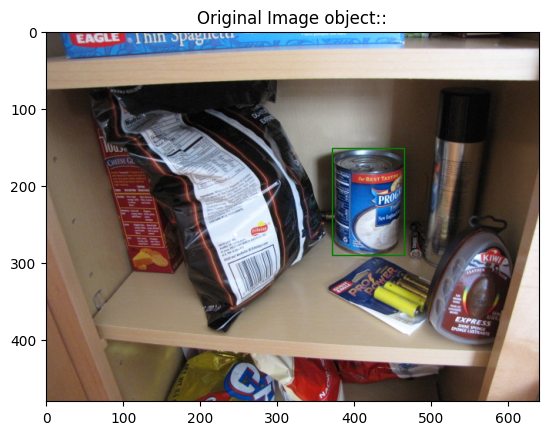

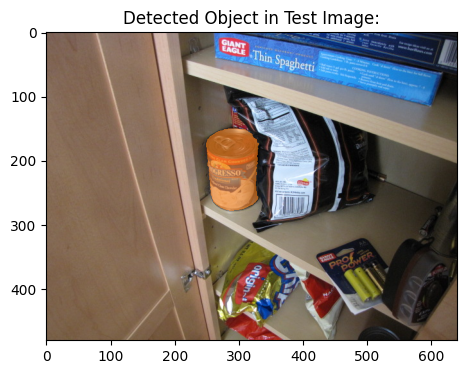

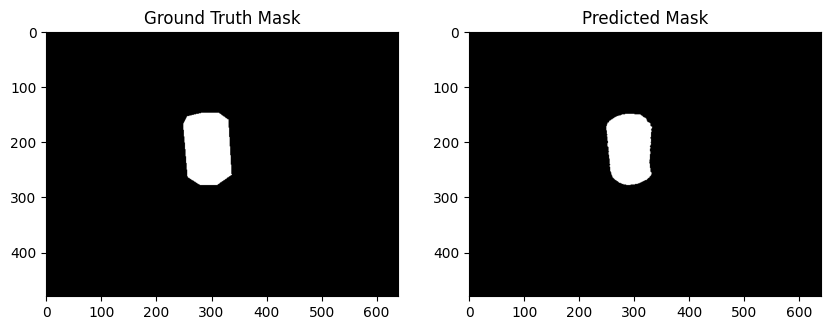

Predicted Bounding Box: [249, 331, 150, 278]
Ground Truth Bounding Box: [249, 336, 148, 278]
IoU for ./CMU10_3D/CMU10_3D/data_2D/can_chowder_000002.jpg: 0.928028293545535
Final IoU: 0.928028293545535


In [57]:
# Paths to the first image, its mask, and the second image
firstimgpath = './CMU10_3D/CMU10_3D/data_2D/can_chowder_000001.jpg'
firstimgmaskpath = './CMU10_3D/CMU10_3D/data_2D/can_chowder_000001_1_gt.png'
secondimgpath = './CMU10_3D/CMU10_3D/data_2D/can_chowder_000002.jpg'
secondimgmaskpath = './CMU10_3D/CMU10_3D/data_2D/can_chowder_000002_1_gt.png'

# Get bounding box from first image and mask
[xmin, xmax, ymin, ymax] = process_img_png_mask(firstimgpath, firstimgmaskpath)
img1boxclasslist = [([xmin, xmax, ymin, ymax], 1)]  # Object 1 with ID = 1

# Track objects in other images and evaluate performance
iou = evaluate_performance(firstimgpath, secondimgpath, secondimgmaskpath, img1boxclasslist)
print(f"Final IoU: {iou}")

In [ ]:
# Final IoU: 0.928028293545535
# By which we can say a good overlap,  the predicted bounding box is almost identical to the ground truth.